# Table of Contents

* [Introduction](#Introduction)
* [Section 1 Functions-For-Processing](#Functions-For-Processing)
    * [Section 1.1 Import Libraries](#Import-Libraries)
    * [Section 1.2 Transform-a-time-series-dataset-into-a-supervised-learning-dataset](#Transform-a-time-series-dataset-into-a-supervised-learning-dataset)
    * [Section 1.3 Split-a-univariate-dataset-into-train/test-sets](#Split-a-univariate-dataset-into-train/test-sets)
    * [Section 1.4 Fit-an-random-forest-model-and-make-a-one-step-prediction](#Fit-an-random-forest-model-and-make-a-one-step-prediction)
    * [Section 1.5 Walk-forward-validation-for-univariate-data](#Walk-forward-validation-for-univariate-data)
* [Section 2 Processing-and-Evaluation](#Processing-and-Evaluation)
     * [Section 2.1 Analysis-based-on-60-days-input-data](#Analysis-based-on-60-days-training-data)
         * [Section 2.1.1 load-the-dataset](#Load-the-60-days-data)
         * [Section 2.1.2 Evaluate](#Analysis-based-on-60-days-training-data)
         * [Section 2.1.3 Insight](#Insight-for-60-days-Training-Data-Evaluation)
     * [Section 2.2 Analysis-based-on-30-days-input-data](#Analysis-Based-On-30-Days-Training-Data)
         * [Section 2.2.1 Load-the-data](#Load-the-30-days-data)
         * [Section 2.2.2 Evaluate](#Analysis-based-on-30-days-training-data)
         * [Section 2.2.3 Insight](#Insight-for-30-days-Training-Data)
* [Section 3 Summary](#Summary)
     * [Section 3.1 Suggestions](#Suggestions)
         
    



# Introduction <a class="anchor" id="Introduction"></a>

This notebook contains data analysis and processing of glucose data of a patient to obtain key insights and get future predictions of data. 

The notebook is divided into two sections:
1. In the first section all the fuctions have been defined that can be called anywhere is the notebook. These functions include:

 a) Transform a time series dataset into a supervised learning dataset.
 
 b) Split a univariate dataset into train/test sets
 
 c) Fit a random forest model and make a one step prediction
 
 d) Walk-forward validation for univariate data
 

2. The section 2 utilizes all the fuctions that have been developed in section 1 to evaluate and predict the results. 

## a) Transform a time series dataset into a supervised learning dataset
This step transforms time series data into a supervised learning dataset for better prediction scores. The dataset is made in such a way that the original univariate data is provided multiple columns which, these colums have values from previous datapoints. Ths creates a dependency and colinear relation between datapoints as they progress. When this relation between datapoints is learned by the model, it performs better as compared to a non-supervised dataset. 

## b) Split a univariate dataset into train/test sets
This step is key for any model, we need to divide our dataset into train and test sets. Generally a 80% train and 20% test is considered. 

##  c) Fit a SVR model and make a one step prediction
In machine learning, Support Vector Machines are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. In Support Vector Regression, the straight line that is required to fit the data is referred to as hyperplane.
The objective of a support vector machine algorithm is to find a hyperplane in an n-dimensional space that distinctly classifies the data points. The data points on either side of the hyperplane that are closest to the hyperplane are called Support Vectors. These influence the position and orientation of the hyperplane and thus help build the SVM.


## d) Walk-forward validation for univariate data
Walk forward validation is an important step in this kind of data, specially if the data is continuously streaming in. We need a model that can cater for new data points while predicting the next data points. In this notebook, we perform a 12 point walk forward validation. 

In short we train our model on a specific amount of training data and predict the next 12 data points, after ths prediction the 12 predicted data points are then merged into the training data and next 12 data points are predicted. In this way we can take input from real time streaming data and add it to the process of predicting future values. 

# Functions-For-Processing

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import time
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from matplotlib import pyplot

## Transform a time series dataset into a supervised learning dataset

This steps includes converting a naive time series data into a supervised dataset. The number of values to be used as lag for supervised dataset is sent as a parameter to the function. 


The function takes the original dataset and add columns infront of each data value. These columns are bascially the preceding values to that particular value, in the time series. 

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

## Split a univariate dataset into train/test sets

In [3]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

## Fit a SVR model and make a one step prediction


In [4]:
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = SVR()
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

## Walk-forward validation for univariate data


In [5]:
def walk_forward_validation(data, n_test):
    data = series_to_supervised(data, n_in=6)
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # history.append(test[i]) # use only if: add actual observation to history for the next loop
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    rmse = mean_squared_error(test[:, -1], predictions)
    rmse = (rmse) ** (0.5)
    return error, test[:, -1], predictions, rmse

# Processing-and-Evaluation

## Analysis based on 60 days training data

### Load the 60 days data

,0
count,17274.000000
mean,129.411485
std,41.198385
min,39.000000
25%,102.000000
50%,122.000000
75%,150.000000
max,386.000000


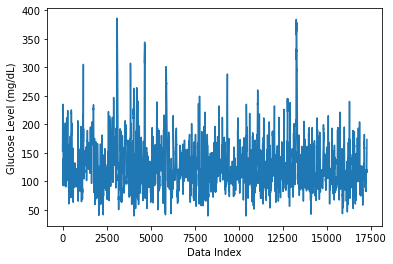

In [6]:
series = read_csv(
    r'C:\Users\ahtis\OneDrive\Desktop\data\data.csv', header=0, index_col=0)
values = series.values

# Read 60 days of data from the dataset for validation. Each datapoint is recorded with 5 minute interval in between.
# (12 points in an hour, 288 points in a day, 17280 in 60 days)

data = values[0:17280]
data1 = values[0:17280]
pyplot.plot(data, label='Glucose Data')

pyplot.xlabel('Data Index')
pyplot.ylabel('Glucose Level (mg/dL)')

data1 = pd.DataFrame(data)
data1.describe()

### Analysis based on 60 days training data

>expected=84.0, predicted=81.0
>expected=85.0, predicted=83.4
>expected=86.0, predicted=84.9
>expected=86.0, predicted=86.4
>expected=82.0, predicted=86.7
>expected=82.0, predicted=82.6
>expected=88.0, predicted=82.1
>expected=91.0, predicted=88.4
>expected=96.0, predicted=92.3
>expected=96.0, predicted=98.5
>expected=102.0, predicted=98.8
>expected=105.0, predicted=105.2
>expected=111.0, predicted=108.1
>expected=113.0, predicted=114.7
>expected=111.0, predicted=116.2
>expected=110.0, predicted=112.7
>expected=111.0, predicted=110.5
>expected=110.0, predicted=111.2
>expected=114.0, predicted=109.7
>expected=116.0, predicted=115.0
>expected=112.0, predicted=117.5
>expected=110.0, predicted=111.9
>expected=104.0, predicted=109.2
>expected=102.0, predicted=101.8
>expected=101.0, predicted=99.7
>expected=99.0, predicted=99.4
>expected=99.0, predicted=97.7
>expected=99.0, predicted=98.4
>expected=99.0, predicted=98.8
>expected=99.0, predicted=99.0
>expected=102.0, predicted=99.2
>expected=

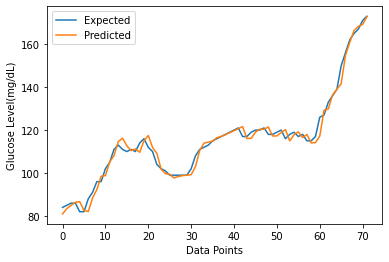

--- 1296.216364622116 seconds ---


In [7]:
mean_abs_error = list()
start_time = time.time()
for i in range(1):
    mae, y, yhat,rmse = walk_forward_validation(data, 72)
    print('MAE: %.3f' % mae)
    print('RMSE: %.3f' % rmse)
    #data = values[len(data)-2:len(data)+len(data)-2, :]
    #yhat = np.asarray(yhat)
    # print('yhat',yhat.shape)
    #yhat_append = series_to_supervised(yhat, n_in=6)
    #print('yhat append',yhat_append.shape)
    #y_append = np.asarray(y)
    #data = np.append(data, y_append)
    #data = np.reshape(data, (-1, 1))
    data = values[0:len(data)+72,:]
    mean_abs_error.append(mae)
    pyplot.plot(y, label='Expected')
    pyplot.plot(yhat, label='Predicted')
    pyplot.xlabel("Data Points")
    pyplot.ylabel("Glucose Level(mg/dL)")
    #pyplot.title('Loss: MAE = %f' % (mae) , 'Loss: MSE = %f' % (mse) )
    pyplot.legend()
    pyplot.show()

print("--- %s seconds ---" % (time.time() - start_time))

### Insight for 60 days Training Data Evaluation

Using the 60 Day time period for our data, we are able to iterate two time over the data set. Here we are predicting next 72 points which is next 6 hours of data. 

The Key Insight is that as we progress in the foward 72 step validation the MAE and MSE remains almost constant. 

Model is considered to be useful if MAE and RMSE is less than 6/7 in general, since the trend is maintained and loss parameters are in desired range the model can be considered for further testing. Higher MAE/RMSE can further distort the prediction as compared to original values. 

## Analysis Based On 30 Days Training Data

### Load the 30 days data

,0
count,8634.000000
mean,131.939889
std,44.110320
min,39.000000
25%,102.000000
50%,125.000000
75%,154.000000
max,386.000000


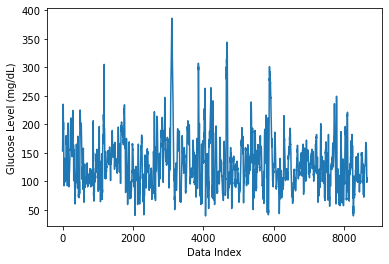

In [8]:
series = read_csv(
    r'C:\Users\ahtis\OneDrive\Desktop\data\data.csv', header=0, index_col=0)
values = series.values

# Read 60 days of data from the dataset for validation. Each datapoint is recorded with 5 minute interval in between.
# (12 points in an hour, 288 points in a day, 8640 in 30 days)

data = values[0:8640]
data1 = values[0:8640]
pyplot.plot(data, label='Glucose Data')

pyplot.xlabel('Data Index')
pyplot.ylabel('Glucose Level (mg/dL)')

data1 = pd.DataFrame(data)
data1.describe()

### Analysis based on 30 days training data

>expected=110.0, predicted=110.9
>expected=110.0, predicted=111.8
>expected=113.0, predicted=111.6
>expected=116.0, predicted=114.3
>expected=116.0, predicted=117.5
>expected=116.0, predicted=117.6
>expected=120.0, predicted=117.2
>expected=121.0, predicted=121.2
>expected=122.0, predicted=122.3
>expected=124.0, predicted=123.2
>expected=126.0, predicted=125.2
>expected=127.0, predicted=127.2
>expected=127.0, predicted=128.1
>expected=126.0, predicted=127.8
>expected=127.0, predicted=126.2
>expected=127.0, predicted=126.9
>expected=127.0, predicted=126.8
>expected=127.0, predicted=126.8
>expected=128.0, predicted=126.8
>expected=128.0, predicted=127.9
>expected=128.0, predicted=127.9
>expected=128.0, predicted=127.9
>expected=128.0, predicted=127.8
>expected=128.0, predicted=127.7
>expected=130.0, predicted=127.7
>expected=131.0, predicted=130.0
>expected=134.0, predicted=131.3
>expected=135.0, predicted=134.8
>expected=136.0, predicted=136.1
>expected=138.0, predicted=136.9
>expected=

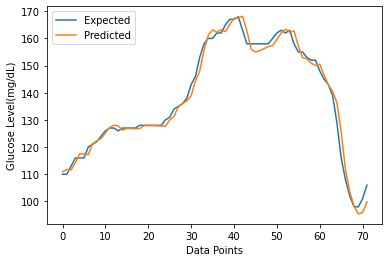

>expected=111.0, predicted=106.5
>expected=115.0, predicted=113.3
>expected=119.0, predicted=118.5
>expected=125.0, predicted=122.8
>expected=131.0, predicted=128.8
>expected=138.0, predicted=134.9
>expected=142.0, predicted=142.2
>expected=150.0, predicted=146.1
>expected=156.0, predicted=154.0
>expected=164.0, predicted=160.1
>expected=172.0, predicted=168.0
>expected=180.0, predicted=176.0
>expected=187.0, predicted=183.6
>expected=193.0, predicted=190.1
>expected=196.0, predicted=195.5
>expected=191.0, predicted=198.2
>expected=185.0, predicted=193.5
>expected=180.0, predicted=185.6
>expected=167.0, predicted=178.1
>expected=150.0, predicted=163.9
>expected=132.0, predicted=145.9
>expected=112.0, predicted=128.3
>expected=100.0, predicted=112.4
>expected=90.0, predicted=103.0
>expected=82.0, predicted=94.0
>expected=81.0, predicted=85.7
>expected=84.0, predicted=82.2
>expected=88.0, predicted=82.9
>expected=93.0, predicted=87.0
>expected=96.0, predicted=93.2
>expected=101.0, predic

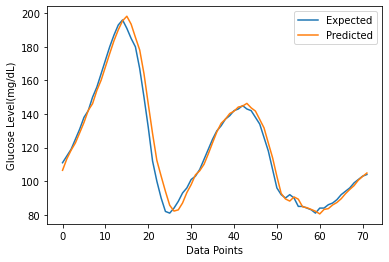

>expected=106.0, predicted=105.9
>expected=108.0, predicted=107.7
>expected=106.0, predicted=109.6
>expected=105.0, predicted=107.3
>expected=103.0, predicted=105.6
>expected=101.0, predicted=103.0
>expected=100.0, predicted=100.4
>expected=99.0, predicted=99.1
>expected=99.0, predicted=98.3
>expected=99.0, predicted=98.4
>expected=99.0, predicted=98.7
>expected=100.0, predicted=99.0
>expected=100.0, predicted=100.2
>expected=98.0, predicted=100.4
>expected=100.0, predicted=98.3
>expected=105.0, predicted=100.1
>expected=106.0, predicted=105.7
>expected=106.0, predicted=107.6
>expected=104.0, predicted=107.8
>expected=104.0, predicted=105.4
>expected=106.0, predicted=104.5
>expected=106.0, predicted=106.1
>expected=106.0, predicted=106.4
>expected=107.0, predicted=106.5
>expected=105.0, predicted=107.7
>expected=102.0, predicted=105.5
>expected=103.0, predicted=101.8
>expected=103.0, predicted=102.5
>expected=101.0, predicted=102.7
>expected=96.0, predicted=100.8
>expected=96.0, predic

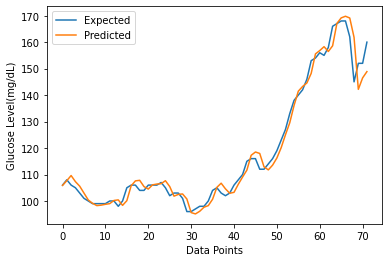

--- 983.2772393226624 seconds ---


In [9]:
mean_abs_error = list()
start_time1 = time.time()
for i in range(1):
    mae, y, yhat, rmse = walk_forward_validation(data, 72)
    print('MAE: %.3f' % mae)
    print('RMSE: %.3f' % rmse)
    #data = values[len(data)-2:len(data)+len(data)-2, :]
    #yhat = np.asarray(yhat)
    # print('yhat',yhat.shape)
    #yhat_append = series_to_supervised(yhat, n_in=6)
    #print('yhat append',yhat_append.shape)
    #y_append = np.asarray(y)
    #data = np.append(data, y_append)
    #data = np.reshape(data, (-1, 1))
    data = values[0:len(data)+72,:]
    mean_abs_error.append(mae)
    pyplot.plot(y, label='Expected')
    pyplot.plot(yhat, label='Predicted')
    pyplot.xlabel("Data Points")
    pyplot.ylabel("Glucose Level(mg/dL)")
   # pyplot.title('Loss: MAE = %f' % (mae) ,'Loss: MSE = %f' % (mse))
    pyplot.legend()
    pyplot.show()
print("--- %s seconds ---" % (time.time() - start_time1))

### Insight for 30 days Training Data

Using the 30 Day time period for our data, we are able to iterate four times over the data set. Here we are predicting next 72 points which is next 6 hours of data. 

The Key Insight is that as we progress in the foward 72 step validation the MAE and MSE almost remains constant. 

Model is considered to be useful if MAE and RMSE is less than 6/7 in general, since the trend is maintained and loss parameters are in desired range the model can be considered for further testing. Higher MAE/RMSE can further distort the prediction as compared to original values. 

# Summary

If we increase the number of iterations the MAE and MSE is almost constant, with slight up and down variations based on particular input data. The model is behaving good in terms of accuracy and is able to capture future prediction trends. 

## Suggestions

1. Increasing the input dataset may(not necessarily) decrease the overall error rate.
2. Model is performing good enough and can be deployed in a practical scenario on test trials for further evaluation. 

